This notebook is a personal implementation of the paper [**Supervised Learning with Tensor Networks**](https://papers.nips.cc/paper_files/paper/2016/hash/5314b9674c86e3f9d1ba25ef9bb32895-Abstract.html) by _E. M. Stoudenmire_ and _David J. Schwab_ , 2016.

## Imports:

In [1]:
# Relevant packages
import jax.numpy as jnp # To perform operations on the MPS and embedded data
import random
import pandas as pd # store output data in a table format
from timeit import default_timer as timer # to keep track of the times
import numpy as np
import torch # To perform operations on the dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms # To import the dataset

# Personalized python scripts for creating the MPS, embedding the data as the paper, and for the sweeper algorithm
from Embedding import embedding,one_hot_encoding
from MPS import mps as class_mps
from Sweeper import sweeper

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

## GPU or CPU:

Set device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')


Using device cpu


## Set dataloaders:

Setting the pytorch dataloaders, for the MNIST dataset. The original dataset is splitted in training, validation and testing.

In [3]:
# Define batch size and device
batch_size = 2000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define transformations for resizing and converting to tensor
transform = transforms.Compose([
    transforms.Resize(14),  # Resize the images to 14x14
    transforms.ToTensor()   # Convert images to PyTorch tensors
])

# Initialize the dataset
dataset = datasets.MNIST('data', train=True, download=True, transform=transform)

# Split the dataset into train, validation, and test sets
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [40000, 10000, 10000])

# Define DataLoaders based on device (GPU or CPU)
if device == 'cuda':
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
    )
    validation_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=int(batch_size*0.25), shuffle=True, num_workers=1, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=int(batch_size*0.25), shuffle=True, num_workers=1, pin_memory=True
    )
else:
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size, shuffle=True
    )
    validation_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=int(batch_size*0.25), shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=int(batch_size*0.25), shuffle=True
    )



## Left-right canonical

This helper function checks whether the MPS tensor in the position _i_ is left or right canonical.

In [4]:
def check_orthonormality(left_or_right,mps_i,i):
    '''This function will check whether a tensor is left or right canonical.
    
    Args :
        - left_or_right (bool): Site where the tensor is canonical.
        - mps_i (JAX.Numpy.Array, shape: (bond_dim,physical_leg) or (bond_dim,physical_leg,bond_dim) 
            or (physical_leg,bond_dim) ): Tensor to check.
        -  i (int): Index of the MPS tensor.
    
    Returns :
        [empty]
    '''
    if left_or_right=='left':
        if i ==0:
            if jnp.allclose( jnp.eye(mps_i.shape[1]),jnp.round ( jnp.einsum('jk, jl-> kl ',mps_i,mps_i), 6), rtol=1e-03, atol=1e-04) :
                j=0
            else:
                print( 'Left orthonormalized')
                print('Index : ',i)
                print('Not correct')
        else : 
            if  jnp.allclose( jnp.eye(mps_i.shape[2]),jnp.round ( jnp.einsum('ijk, ijl-> kl ',mps_i,mps_i), 6), rtol=1e-03, atol=1e-04):
                j=0
            else:
                print( 'Left orthonormalized')
                print('Index : ',i)
                print('Not correct')

    if left_or_right == 'right':
        if i==195:
            if jnp.allclose( jnp.eye(mps_i.shape[0]), jnp.round ( jnp.einsum('ij, kj-> ik ',mps_i,mps_i), 6), rtol=1e-03, atol=1e-04,):
                j=0
            else:
                print( 'Right orthonormalized')
                print('Index : ',i)
                print('Not correct')
        else : 
            if  jnp.allclose( jnp.eye(mps_i.shape[0]),jnp.round ( jnp.einsum('ijk, ljk-> il ',mps_i,mps_i), 6), rtol=1e-03, atol=1e-04):
                j=0
            else:
                print( 'Right orthonormalized')
                print('Index : ',i)
                print('Not correct')

## Contract MPS:

This function will contract the MPS with the validation or testing data.

In [5]:
def contract_mps_embedded_data(mps, y_val,embeddings_val,position_l):
    ''' This function will contract the MPS with the previously transformed and embbeded images data. This contraction ends with an array of size 10,
    the predicted one-hot encoded label, that will be compared against the true label. 
    
    Args:
        - mps (list[JAX.Numpy.Array: float], 
                shape: List[(physical_leg,bond_dim), (bond_dim, physical_leg,bond_dim), ..., (bond_dim, physical_leg, bond_dim, l_leg), 
                ..., (bond_dim, physical_leg, bond_dim),.., (bond_dim, physical_leg) ]): This variable is a list full of tensors of the MPS.
        - y_val (JAX.Numpy.Array: float, shape : (#_data,10)): One hot encoded labels.
        - embeddings_val(JAX.Numpy.Array: float, shape: (#_data, image_size_flatten, physical_leg)): Images data embedded.
        - position_l (int): Position of the tensor with the l leg on the mps list.
    Returns:
        - accuracy (float): Percentage of accuracy.
        - cost (JAX.Array: (float), shape : (1)): Cost or loss of the 0.5*(predicted labels - true_labels)^2 for the images batch.
    '''
    accuracy=0
    cost=0
    
    for index_val in range( y_val.shape[0]): 
        for index_left in range(position_l):
            # Contract from the leftest position the MPS with one image
            if index_left ==0:
                left_side=jnp.einsum( 'ij,i->j', mps[index_left],embeddings_val[index_val,index_left,:])
                left_side=left_side / jnp.linalg.norm(left_side)
            
            else:
                left_side=jnp.einsum( 'ijk,i->jk', mps[index_left],left_side)
                left_side=jnp.einsum( 'jk,j->k', left_side,embeddings_val[index_val,index_left,:])
                left_side=left_side / jnp.linalg.norm(left_side)
        
        for index_right in reversed(range(position_l+1,len(mps))):
            # Contract from the rightest position the MPS with one image
            if index_right==len(mps)-1:
                right_side=jnp.einsum( 'ij,j->i', mps[index_right],embeddings_val[index_val,index_right,:])
                right_side=right_side / jnp.linalg.norm(right_side)
            
            else:
                right_side=jnp.einsum( 'ijk,k->ij', mps[index_right],right_side)
                right_side=jnp.einsum( 'ij,j->i', right_side,embeddings_val[index_val,index_right,:])
                right_side=right_side / jnp.linalg.norm(right_side)
        
        # Once compute the left and right legs to contract with mps in the position_l, proceed with further contraction
        if position_l==0:
            f_l=jnp.einsum('jkl,j->kl',mps[position_l],embeddings_val[index_val,position_l,:])
            f_l=jnp.einsum('k,kl->l',right_side,f_l)
        elif position_l==len(mps)-1:
            f_l=jnp.einsum( 'i,ijl->jl',left_side,mps[position_l])
            f_l=jnp.einsum('jl,j->l',f_l,embeddings_val[index_val,position_l,:])
        else:
            f_l=jnp.einsum( 'i,ijkl->jkl',left_side,mps[position_l])
            f_l=jnp.einsum('jkl,j->kl',f_l,embeddings_val[index_val,position_l,:])
            f_l=jnp.einsum('k,kl->l',right_side,f_l)
        
        # Compute one_hot encoding of the predicted label to compute the accuracy
        predicted_level=np.zeros(f_l.shape)
        predicted_level[np.argmax(f_l)]=1
        predicted_level=jnp.array(predicted_level,dtype=float)
        
        # Sum the accuracy of one image and the cost of one image to the total
        accuracy+= int(all(predicted_level == y_val[index_val,:]))
        cost+=0.5*jnp.dot( ( predicted_level-y_val[index_val,:]),( predicted_level-y_val[index_val,:]))

    return ( (accuracy / y_val.shape[0])*100), cost

In [6]:
def check_cost_and_accuracy_val_or_test(mps, position_l, loader, device):
    ''' This function will drawn samples from a pytorch loader, next it will embedd these as the paper specifies. Finally, it will call the function
    contract_mps_embedded_data to compute the cost and accuracy of the drawn samples.

    Args:
        - mps (list[JAX.Numpy.Array: float], 
                shape: List[(physical_leg,bond_dim), (bond_dim, physical_leg,bond_dim), ..., (bond_dim, physical_leg, bond_dim, l_leg), 
                ..., (bond_dim, physical_leg, bond_dim),.., (bond_dim, physical_leg) ]): This variable is a list full of tensors of the MPS.
        - position_l (int): Position of the tensor with the l leg on the mps list.
        - loder(pytorch.dataloader): Loader from where extract the samples.
        - device(str): Available device.
    
    Returns:
        - accuracy (float): Percentage of accuracy.
        - cost (JAX.Array float): cost.
    '''

    batch = random.choice(list(loader))  # Randomly selects a batch from the loader
    x, y = batch
    inputs_embedding=embedding(x).to(device)
    embeddings=inputs_embedding.inputs_embedded()
    embeddings=jnp.array(embeddings,dtype=float)
    y=jnp.array( one_hot_encoding(y), dtype=float)
    accuracy, cost=contract_mps_embedded_data(mps=mps, y_val=y,embeddings_val=embeddings,position_l=position_l)
    
    return accuracy,cost
        
    


## Computing

Steps:
- $1^{st}$ : Initialize a random MPS left or right canonical, depending on the position of l. Initialize the pandas tables where we will store the results.
- $2^{nd}$ : Create the initial data contraction of the MPS with the training data. We will store in a List[List[jnp.Array]]. This initial data will contain the left or right legs, one dimensional arrays, to contract with the joint tensor to optimize (see paper).
- $3^{rd}$ : Starts the sweeping optimization of the MPS. At each step it will compute the training and validations costs and accuracies and store them in the pandas table. We also visualize the in live process with the tensorboard. Depending on where we start, the optimization loop has to vary.
- $4^{th}$: Store the results in a csv file.

In [ ]:
bond_dims=[5,10,15,20]
phys_dim=2
length=14*14
l_dim=10
std=1
mean=0
learning_rate=0.005
position_l=0
left_or_right='left'
Nsweeps=3
path_variable='Your path ...'
for bond_dim in bond_dims:

        # 1 : Initialize mps, training data samples with the corresponding embedding and pandas table.
        mps=class_mps(bond_dim=bond_dim, in_dim=phys_dim,length=length,l_dim=l_dim,std=std,mean=mean,position_l=position_l).canonical_form()
        writer = SummaryWriter(log_dir=path_variable+"training_mps/bond_dim_tests"+str(bond_dim)) # To visualize training and validation in real time.
        batch = random.choice(list(train_loader))  # Randomly selects a batch from the loader
        x_train, y_train = batch
        inputs_embedding=embedding(x_train).to(device)
        embeddings_train=inputs_embedding.inputs_embedded() # Embedded images
        embeddings_train=jnp.array(embeddings_train,dtype=float) # Transform to jnp array
        y_train=jnp.array( one_hot_encoding(y_train), dtype=float)
        df = pd.DataFrame()
        df_1 = pd.DataFrame()
        df_2 = pd.DataFrame()

        # 2 : Creating the initial left or right legs MPS-training data contracted
        data=[]
        data_training=[]
        print('Starting creating data')
        
        if left_or_right=='right':

                # Left to right (so initalization from the right)
                for index_mps in range(len(mps)):
                        data_training=[]
                        for index_training in range(embeddings_train.shape[0]):
                                if index_mps==0:
                                        temporary_mps=jnp.einsum('ij, i ->j' ,mps[index_mps],embeddings_train[index_training,index_mps,:])
                                        data_training.append(temporary_mps / jnp.linalg.norm(temporary_mps )) 
                                
                                elif index_mps==len(mps)-1:
                                        temporary_mps=jnp.einsum('ijk, j ->ik' ,mps[index_mps],embeddings_train[index_training,index_mps,:])
                                        temporary_mps = jnp.einsum('i, ik ->k',data[index_training][-1], temporary_mps)
                                        data_training.append( temporary_mps / jnp.linalg.norm(temporary_mps ) )
                                else:
                                        temporary_mps=jnp.einsum('ijk, j ->ik' ,mps[index_mps],embeddings_train[index_training,index_mps,:])
                                        temporary_mps = jnp.einsum('i, ij ->j',data[index_training][-1], temporary_mps)
                                        data_training.append( temporary_mps / jnp.linalg.norm(temporary_mps ) )
                                
                        if index_mps==0:
                                data_training = [[single_data_training] for single_data_training in data_training]
                                data=data_training
                        
                        else:
                                # shape data : (#_training,length_mps)
                                # Creates a new column for the current MPS position. It fills the data from left to right.
                                data = [ data_row + [data_training_row] for data_row, data_training_row in zip(data, data_training)]
                                
        if left_or_right=='left':

                # Right to left ( so initalization from the left)
                for index_mps in reversed(range(len(mps))):
                        data_training=[]
                        for index_training in range(embeddings_train.shape[0]):
                                if index_mps==len(mps)-1:
                                        temporary_mps= jnp.einsum('ij, j ->i' ,mps[index_mps], embeddings_train[index_training,index_mps,:])
                                        data_training.append(temporary_mps / jnp.linalg.norm(temporary_mps))
                                                
                                elif index_mps==0:
                                        temporary_mps=jnp.einsum('ijk, i ->jk' ,mps[index_mps], embeddings_train[index_training,index_mps,:])
                                        temporary_mps=jnp.einsum('jk, j-> k',temporary_mps ,data[index_training][0])
                                        data_training.append( temporary_mps/  jnp.linalg.norm(temporary_mps))

                                else:
                                        temporary_mps=jnp.einsum('ijk, j ->ik' ,mps[index_mps], embeddings_train[index_training,index_mps,:])
                                        temporary_mps=jnp.einsum('ij, j ->i',temporary_mps ,data[index_training][0])
                                        data_training.append( temporary_mps/  jnp.linalg.norm(temporary_mps))
                                        
                        
                        if index_mps==len(mps) -1:
                                data_training = [[single_data_training] for single_data_training in data_training]
                                data=data_training
                        else:
                                # shape data : (#_training,length_mps)
                                # Creates a new column for the current MPS position. It fills the data from right to left.
                                data = [ [data_training_row] + data_row for data_row, data_training_row in zip(data, data_training)]
        print('End creating data')

        # 3 : Start sweeping
        print('Starting sweeps')
        for sweep_index in range(Nsweeps):
                print('sweep number : ',sweep_index)
                if left_or_right=='right':
                        print('Right to left')
                        start = timer() # 
                        for index_mps in reversed(range(1,len(mps))):
                                # Update MPS and compute accuracies validation
                                mps, data, cost, accuracy=sweeper(mps=mps, phi=embeddings_train,learning_rate=learning_rate,bond_dim=bond_dim, j=index_mps,y=y_train, data=data).update_mps(left_or_right='right')
                                accuracy_val,cost_val=check_cost_and_accuracy_val_or_test(mps=mps,position_l=index_mps-1,loader=validation_loader,device=device)
                                # Add results to the config file of the Tensorboard
                                writer.add_scalar('Training Cost', float(cost), sweep_index * 2*(length-1) + (length-index_mps))
                                writer.add_scalar('Training Accuracy', float(accuracy*100), sweep_index * 2*(length-1) + (length-index_mps))
                                writer.add_scalar('Validation Cost', float(cost_val), sweep_index * 2*(length-1) + (length-index_mps))
                                writer.add_scalar('Validation Accuracy', float(accuracy_val), sweep_index * 2*(length-1) + (length-index_mps))           
                                #check_orthonormality(left_or_right='right',mps_i=mps[index_mps],i=index_mps)
                                df_0=pd.DataFrame({'bond_dim': [bond_dim],'cost_train': [cost],'accuracy_train':[accuracy],'cost_validation': [cost_val],'accuracy_validation': [accuracy_val],'step': [sweep_index * 2*(length-1) + (length-index_mps)]})
                                df=pd.concat([df,df_0], sort=False,ignore_index=True).fillna(0)
                        end=timer()
                        df_0=pd.DataFrame({'bond_dim':[bond_dim],'time_between_one_sweep':[end-start]}) # Store the time of each sweep in one direction
                        df_1=pd.concat([df_1,df_0],sort=False, ignore_index=True).fillna(0)
                        
                        print('Left to right')
                        start = timer()
                        for index_mps in range(len(mps)-1):
                                # Update MPS and compute accuracies validation
                                mps, data, cost, accuracy=sweeper(mps=mps, phi=embeddings_train,learning_rate=learning_rate,bond_dim=bond_dim, j=index_mps,y=y_train, data=data).update_mps(left_or_right='left')
                                accuracy_val,cost_val=check_cost_and_accuracy_val_or_test(mps=mps,position_l=index_mps+1,loader=validation_loader,device=device)
                                # Add results to the config file of the Tensorboard
                                writer.add_scalar('Training Cost', float(cost), sweep_index * 2*(length-1) + index_mps+(length))
                                writer.add_scalar('Training Accuracy', float(accuracy * 100), sweep_index * 2*(length-1) + index_mps+(length))
                                writer.add_scalar('Validation Cost', float(cost_val), sweep_index * 2*(length-1) + index_mps+(length))
                                writer.add_scalar('Validation Accuracy', float(accuracy_val ), sweep_index * 2*(length-1) + index_mps+(length))
                                #check_orthonormality(left_or_right='left',mps_i=mps[index_mps],i=index_mps)
                                df_0=pd.DataFrame({'bond_dim': [bond_dim],'cost_train': [cost],'accuracy_train':[accuracy],'cost_validation': [cost_val],'accuracy_validation': [accuracy_val],'step':[ sweep_index * 2*(length-1) + index_mps+(length)]})
                                df=pd.concat([df,df_0], sort=False, ignore_index=True).fillna(0)
                
                        end=timer()
                        df_0=pd.DataFrame({'bond_dim':[bond_dim],'time_between_one_sweep':[end-start]})
                        df_1=pd.concat([df_1,df_0], sort=False, ignore_index=True).fillna(0)
                if left_or_right == 'left':
                        print('Left to right')
                        start = timer()
                        for index_mps in range(len(mps)-1):
                                # Update MPS and compute accuracies validation
                                mps, data, cost, accuracy=sweeper(mps=mps, phi=embeddings_train,learning_rate=learning_rate,bond_dim=bond_dim, j=index_mps,y=y_train, data=data).update_mps(left_or_right='left')
                                accuracy_val,cost_val=check_cost_and_accuracy_val_or_test(mps=mps,position_l=index_mps+1,loader=validation_loader,device=device)
                                # Add results to the config file of the Tensorboard
                                writer.add_scalar('Training Cost', float(cost), sweep_index * 2*(length-1) + index_mps)
                                writer.add_scalar('Training Accuracy', float(accuracy * 100), sweep_index * 2*(length-1) + index_mps)
                                writer.add_scalar('Validation Cost', float(cost_val), sweep_index * 2*(length-1) + index_mps)
                                writer.add_scalar('Validation Accuracy', float(accuracy_val) , sweep_index * 2*(length-1) + index_mps)
                                #check_orthonormality(left_or_right='left',mps_i=mps[index_mps],i=index_mps)
                                df_0=pd.DataFrame({'bond_dim': [bond_dim],'cost_train': [cost],'accuracy_train':[accuracy],'cost_validation': [cost_val],'accuracy_validation': [accuracy_val],'step': [sweep_index * 2*(length-1) + index_mps]})
                                df=pd.concat([df,df_0], sort=False, ignore_index=True).fillna(0)
                        print('Right to left')
                        end=timer()
                        df_0=pd.DataFrame({'bond_dim':[bond_dim],'time_between_one_sweep':[end-start]})
                        df_1=pd.concat([df_1,df_0], sort=False, ignore_index=True).fillna(0)
                        
                        start = timer()
                        for index_mps in reversed(range(1,len(mps))):
                                # Update MPS and compute accuracies validation
                                mps, data, cost, accuracy=sweeper(mps=mps, phi=embeddings_train,learning_rate=learning_rate,bond_dim=bond_dim, j=index_mps,y=y_train, data=data).update_mps(left_or_right='right')
                                accuracy_val,cost_val=check_cost_and_accuracy_val_or_test(mps=mps,position_l=index_mps-1,loader=validation_loader,device=device)
                                # Add results to the config file of the Tensorboard
                                writer.add_scalar('Training Cost', float(cost), sweep_index * 2*(length-1) + (2*length-index_mps))
                                writer.add_scalar('Training Accuracy', float(accuracy * 100), sweep_index * 2*(length-1) + (2*length-index_mps))
                                writer.add_scalar('Validation Cost', float(cost_val), sweep_index * 2*(length-1) + (2*length-index_mps))
                                writer.add_scalar('Validation Accuracy', float(accuracy_val), sweep_index * 2*(length-1) + (2*length-index_mps))
                                #check_orthonormality(left_or_right='right',mps_i=mps[index_mps],i=index_mps)
                                df_0=pd.DataFrame({'bond_dim': [bond_dim],'cost_train': [cost],'accuracy_train':[accuracy],'cost_validation': [cost_val],'accuracy_validation': [accuracy_val],'step': [sweep_index * 2*(length-1) + (2*length-index_mps)]})
                                df=pd.concat([df,df_0], sort=False, ignore_index=True).fillna(0)
                        end=timer()
                        df_0=pd.DataFrame({'bond_dim':[bond_dim],'time_between_one_sweep':[end-start]})
                        df_1=pd.concat([df_1,df_0],sort=False, ignore_index=True).fillna(0)

        writer.close()

        # 4: Stores the result in a csv file
        df.to_csv(path_variable+'training_mnist_lern_rate_'+str(learning_rate)+'_nsweeps_'+str(Nsweeps)+'_batch_'+str(batch_size)+'start_'+str(left_or_right)+'.csv',mode='a')
        accuracy_test,_=check_cost_and_accuracy_val_or_test(mps=mps,position_l=position_l,loader=test_loader,device=device)
        df_0=pd.DataFrame({'bond_dim': [bond_dim],'accuracy_test': [accuracy_test]})
        df_2=pd.concat([df_2,df_0], ignore_index=True).fillna(0)
        df_2.to_csv(path_variable+'test_mnist_lern_rate_'+str(learning_rate)+'_nsweeps_'+str(Nsweeps)+'_batch_'+str(batch_size)+'start_'+str(left_or_right)+'.csv',mode='a')
        df_1.to_csv(path_variable+'time_mnist_lern_rate_'+str(learning_rate)+'_nsweeps_'+str(Nsweeps)+'_batch_'+str(batch_size)+'start_'+str(left_or_right)+'.csv',mode='a') 

## Import

Import required csv files (files in which the previous data has been saved).

In [7]:
bond_dims=[5,10,15,20]
phys_dim=2
length=14*14
l_dim=10
std=1
mean=0
learning_rate=0.005
position_l=0
left_or_right='left'
Nsweeps=3
batch_size = 2000
training_scores = pd.read_csv(path_variable+'training_mnist_lern_rate_'+str(learning_rate)+'_nsweeps_'+str(Nsweeps)+'_batch_'+str(batch_size)+'start_'+str(left_or_right)+'.csv')
test_scores=pd.read_csv(path_variable+'test_mnist_lern_rate_'+str(learning_rate)+'_nsweeps_'+str(Nsweeps)+'_batch_'+str(batch_size)+'start_'+str(left_or_right)+'.csv').astype(float).reset_index(drop=True)

training_cost_bonds=pd.DataFrame()
training_accuracies_bonds=pd.DataFrame()
validation_cost_bonds=pd.DataFrame()
validation_accuracies_bonds=pd.DataFrame()
test_accuracies_bonds=pd.DataFrame()



# Process data

Rearrange stored data in the dataframe variables for better visualization.

In [9]:
bond_dims=[5,10,15,20]
for bond_dim in bond_dims:
    # We will put the training and tests scores in different data. Each score type will have different set of columns which are the different bond dimensions
    training_scores_bond=training_scores.loc[training_scores['bond_dim'] == bond_dim].astype(float).reset_index(drop=True)
    training_cost_bonds[str(bond_dim)]=training_scores_bond['cost_train'].astype(float)
    training_accuracies_bond=training_scores.loc[training_scores['bond_dim'] == bond_dim].astype(float).reset_index(drop=True)
    training_accuracies_bonds[str(bond_dim)]=100*training_accuracies_bond['accuracy_train'].astype(float)
    validation_scores_bond=training_scores.loc[training_scores['bond_dim'] == bond_dim].astype(float).reset_index(drop=True)
    validation_cost_bonds[str(bond_dim)]=validation_scores_bond['cost_validation'].astype(float)
    validation_accuracies_bond=training_scores.loc[training_scores['bond_dim'] == bond_dim].astype(float).reset_index(drop=True)
    validation_accuracies_bonds[str(bond_dim)]=validation_accuracies_bond['accuracy_validation'].astype(float)
    test_accuracies_bond=test_scores.loc[test_scores['bond_dim'] == bond_dim].astype(float).reset_index(drop=True)
    test_accuracies_bonds[str(bond_dim)]=test_accuracies_bond['accuracy_test'].astype(float)

df_list = [
    ("Training cost", training_cost_bonds),
    ("Training accuracy", training_accuracies_bonds),
    ("Validation cost", validation_cost_bonds),
    ("Validation accuracy", validation_accuracies_bonds)
]


## Plots

Plottings graphs

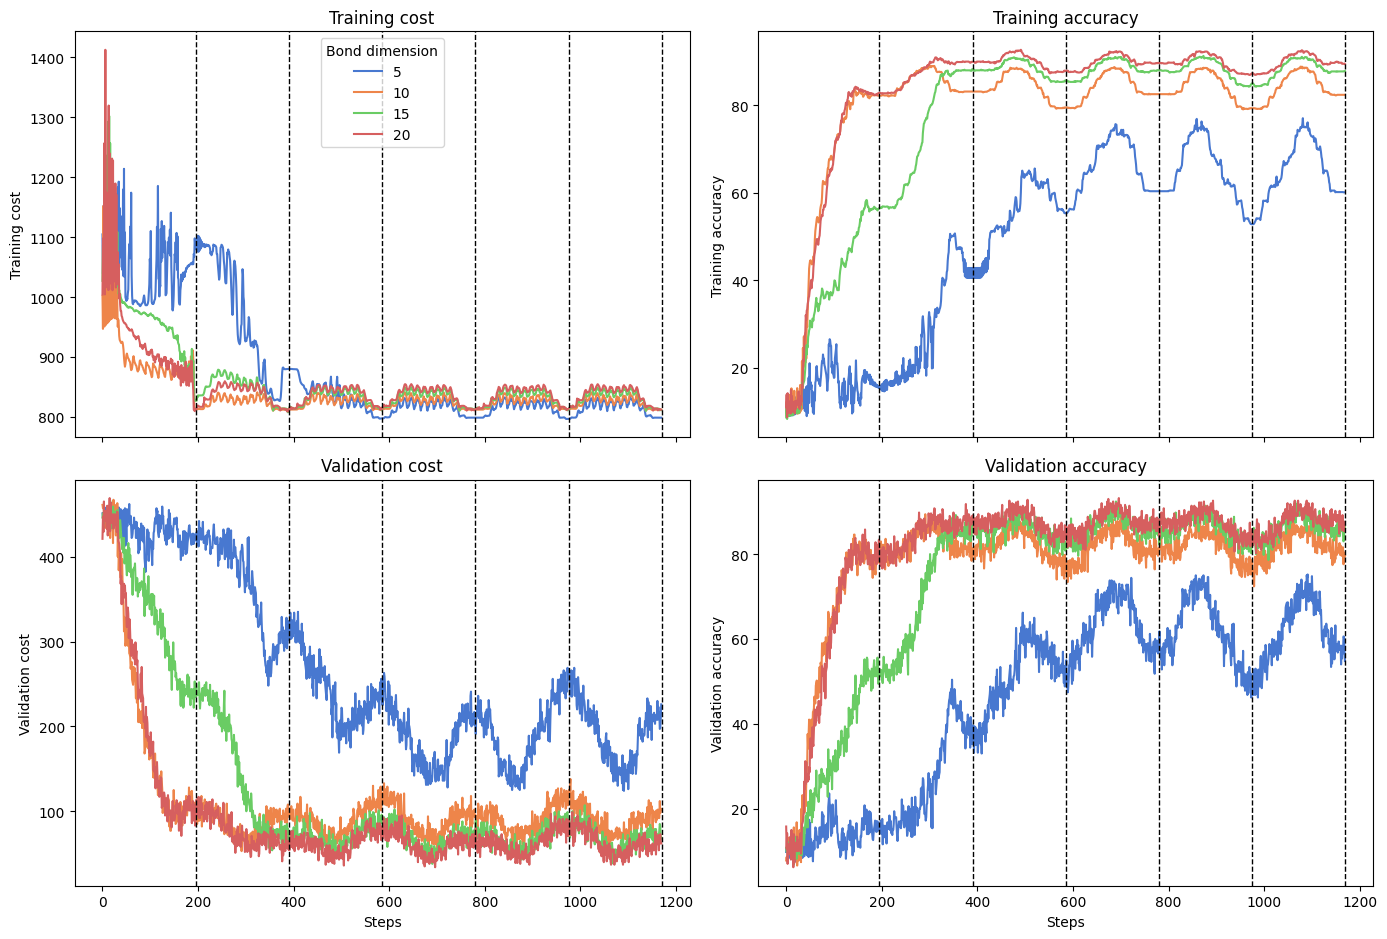

In [10]:
# Set up the figure and axes for a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Define the steps where you want vertical lines
vertical_lines = [195, 2*195, 3*195,4*195, 5*195, 6*195]  # Example steps where you want vertical lines
# Plot each DataFrame in a separate subplot
for i, (title, df) in enumerate(df_list):
    # Convert to long format
    df_long = df.reset_index().melt(id_vars='index', var_name='Bond dimension', value_name=title)
    # For the first plot, enable legend and capture handles and labels
    if i == 0:
        plot = sns.lineplot(
            data=df_long,
            x='index',
            y=title,
            hue='Bond dimension',
            palette='muted',
            ax=axes[i]
        )
        handles, labels = axes[i].get_legend_handles_labels()  # Capture handles and labels
    else:
        # For subsequent plots, disable the legend
        sns.lineplot(
            data=df_long,
            x='index',
            y=title,
            hue='Bond dimension',
            palette='muted',
            ax=axes[i],
            legend=False
        )
    
    # Set titles and labels for each subplot
    axes[i].set_title(title)
    axes[i].set_xlabel('Steps')
    axes[i].set_ylabel(title)

    for step in vertical_lines:
        axes[i].axvline(x=step, color='black', linestyle='--', linewidth=1)  # Customize color and style as needed

# Add a single, shared legend at the upper center of the figure using captured handles and labels
#fig.legend(handles, labels, title="Bond dimension", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=len(df.columns))
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


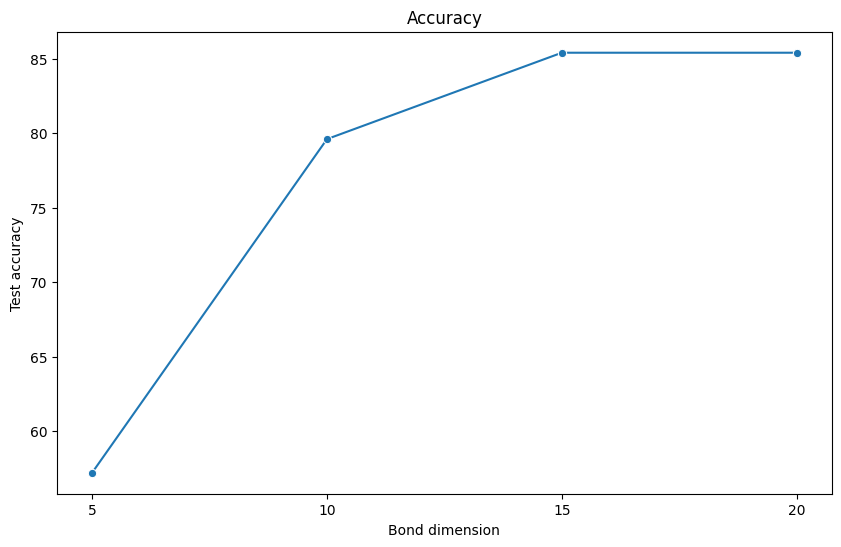

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=test_accuracies_bonds.columns, y=test_accuracies_bonds.iloc[0],marker='o')

# Add labels and title
plt.xlabel('Bond dimension')
plt.ylabel('Test accuracy')
plt.title('Accuracy')

# Show the plot
plt.show()


## Conclusion

Although the MPS learns, the results are not yet satisfactory. More clearful revision has to be made. However, this first run can be used as a base to improve my implementation (incrementing the bond dimension allows for better generalization, yet this trend has to be confirmed with more datasets).

## Improvements

- Avoid code repetition : In general, the code clearness and code efficiency has to be improved.
- Improve numerical stability: As seen from the plots, the results are not close enough to the paper's results.
- Stay with one package, or always jax, or numpy or pytorch. Avoid types conversions.
- GPU code implementation.
- Use different datasets varying in complexity.